# 线性回归

## 基本元素

线性模型：$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$
点积形式：$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$
$b$是误差

### 损失函数

平方误差：$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
常数$\frac{1}{2}$不会带来本质的差别，但这样在形式上稍微简单一些。当我们对损失函数求导后常数系数为1。

### 解析解

线性回归的解可以用一个公式简单地表达出来，这类解叫作解析解（analytical solution）。<br>
首先，我们将偏置 $b$ 合并到参数 $\mathbf{w}$ 中。合并方法是在包含所有参数的矩阵中附加一列。我们的预测问题是最小化 $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$。这在损失平面上只有一个临界点，这个临界点对应于整个区域的损失最小值。将损失关于$\mathbf{w}$的导数设为0，得到解析解（闭合形式）：

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}.$$

### 小批量随机梯度下降

通过不断地在降低损失的方向上更新参数来降低误差。

梯度下降最简单的用法是计算数据集中所有样本的损失关于模型参数的导数（在这里也可以称为梯度）。但实际中的执行可能会比较慢：因为在进行一次更新之前，我们必须遍历整个数据集。因此，**我们通常会在每次需要计算更新的时候随机抽取一小批样本，这种变体叫做小批量随机梯度下降（minibatch stochastic gradient descent）。**

在每次迭代中，我们首先随机抽样一个小批量$\mathcal{B}$，它是由固定数量的训练样本组成的。然后，我们计算小批量的平均损失关于模型参数的导数（也可以称为梯度）。最后，我们将梯度乘以一个预先确定的正数$\eta$，并从当前参数的值中减掉。

我们用下面的数学公式来表示这一更新过程（$\partial$ 表示偏导数）：

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

总结一下，算法的步骤如下：（1）初始化模型参数的值，如随机初始化；（2）从数据中迭代抽取随机的小批量样本。然后在负梯度的方向上更新参数。对于平方损失和仿射变换，我们可以明确地写成如下形式:

$$\begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$


公式中的$\mathbf{w}$ 和 $\mathbf{x}$ 都是向量。在这里，更优雅的向量表示法比系数表示法（如 $w_1, w_2, \ldots, w_d$）更具可读性。
 $|\mathcal{B}|$ 表示每个小批量中的样本数，这也称为*批量大小*（batch size）。$\eta$ 表示 *学习率*（learning rate）。批量大小和学习率的值通常是手动预先指定，而不是通过模型训练得到的。这些可以调整但不在训练过程中更新的参数称为 *超参数*（hyperparameter）。
*调参*（hyperparameter tuning） 是选择超参数的过程。超参数通常是我们根据训练迭代结果来调整的，而训练迭代结果是在独立的*验证数据集*（validation dataset）上评估得到的。

在训练了预先确定的若干迭代次数后（或者直到满足某些其他停止条件后），我们记录估计的模型参数，表示为$\hat{\mathbf{w}}, \hat{b}$。但是，即使我们的函数真是线性的且无噪声。我们估计得到的参数也不会是损失的精确最小值。因为算法会使得损失向最小值缓慢收敛，但不能在有限的步数内非常精确地达到最小值。

线性回归恰好是一个在整个域中只有一个最小值的学习问题。但是对于像深度神经网络这样复杂的模型来说，损失平面上通常包含许多个最小值。幸运的是，深度学习实践者很少努力寻找能够将 *训练集* 损失最小化的参数，虽然这么做原因尚未被完全理解。事实上，更难做到的是找到一组参数，这组参数能够在我们从未见过的数据上实现低的损失，这一挑战被称为 *泛化*（generalization）。

## 矢量化加速

在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。为了实现这一点，需要我们对计算进行矢量化，从而利用好快速线性代数库，而不是在Python中编写开销高昂的for循环。

In [ ]:
!pip install d2l
%matplotlib inline
import math
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

     |████████████████████████████████| 81kB 3.9MB/s 


为了说明矢量化为什么如此重要，我们考虑对两个向量相加的两种方法。
我们实例化两个全1的1000维向量。在一种方法中，我们将使用Python的for循环遍历向量。在另一种方法中，我们将依赖对 `+` 的调用。

In [ ]:
n = 10000
a = tf.ones(n)
b = tf.ones(n)

定义一个计时器

In [ ]:
class Timer:  #@save
    """记录多次运行时间。"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器。"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中。"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间。"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和。"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间。"""
        return np.array(self.times).cumsum().tolist()

现在我们可以对工作负载进行基准测试。

首先，我们使用for循环，每次执行一位的加法。

In [ ]:
c = tf.Variable(tf.zeros(n))
timer = Timer()
for i in range(n):
    c[i].assign(a[i] + b[i])
f'{timer.stop():.5f} sec'

'4.50128 sec'

然后，我们使用重载的 `+` 运算符来计算按元素的和。

In [ ]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00038 sec'

## 正态分布（高斯分布）与平方损失

正态分布概率密度函数如下：

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right)}.$$

下面我们定义一个Python函数来计算正态分布。

In [ ]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

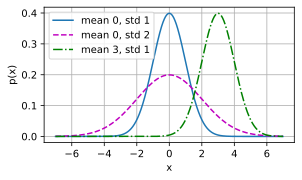

In [ ]:
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

就像我们所看到的，改变均值会产生沿 $x$ 轴的偏移，增加方差将会分散分布、降低其峰值。

利用均方误差损失函数（简称均方损失）可以用于线性回归的一个原因是：假设观测中包含噪声，其中噪声服从正态分布。噪声正态分布如下式:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

因此，我们现在可以写出通过给定的$\mathbf{x}$观测到特定$y$的*可能性*（likelihood）：

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

现在，根据最大似然估计法，参数 $\mathbf{w}$ 和 $b$ 的最优值是使整个数据集的*可能性*最大的值：

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).$$

根据最大似然估计法选择的估计量称为*最大似然估计量* 。
虽然使许多指数函数的乘积最大化看起来很困难，但是我们可以在不改变目标的前提下，通过最大化似然对数来简化。
由于历史原因，优化通常是说最小化而不是最大化。我们可以改为 *最小化负对数似然* $-\log P(\mathbf y \mid \mathbf X)$。由此可以得到的数学公式是：

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

现在我们只需要假设$\sigma$是某个固定常数就可以忽略第一项，因为第一项不依赖于 $\mathbf{w}$和$b$。现在第二项除了常数$\frac{1}{\sigma^2}$外，其余部分和前面介绍的平方误差损失是一样的。
幸运的是，上面式子的解并不依赖于 $\sigma$。因此，**在高斯噪声的假设下，最小化均方误差等价于对线性模型的最大似然估计。**

## 神经网络图

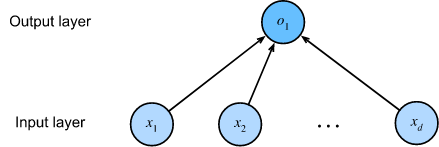

神经网络中，输入为 $x_1, \ldots, x_d$，因此输入层中的 *输入数*（或称为 *特征维度* feature dimensionality）为 $d$。网络的输出为$o_1$，因此输出层中的 *输出数* 是 1。需要注意的是，输入值都是已经给定的，并且只有一个*计算* 神经元。由于模型重点在发生计算的地方，所以通常我们在计算层数时不考虑输入层。也就是说， :numref:`fig_single_neuron` 中神经网络的 *层数* 为1。我们可以将线性回归模型视为仅由单个人工神经元组成的神经网络，或称为单层神经网络。

对于线性回归，每个输入都与每个输出（在本例中只有一个输出）相连，我们将这种变换（ :numref:`fig_single_neuron` 中的输出层）称为 *全连接层*（fully-connected layer）（或称为 *稠密层* dense layer）。


# 线性回归的从零开始实现

## 生成数据集

In [ ]:
%matplotlib inline
!pip install d2l
import random
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
print('features:', features[0], '\nlabel:', labels[0])

features: tf.Tensor([ 0.14810061 -0.5100243 ], shape=(2,), dtype=float32) 
label: tf.Tensor([6.2286625], shape=(1,), dtype=float32)


## 读取数据集

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [ ]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 0.6133809  -0.6113317 ]
 [-2.0862613   0.6992484 ]
 [-0.12381856 -0.12539518]
 [ 1.5493256  -1.3576778 ]
 [-0.49516892  0.48610607]
 [-0.49837202  1.5314432 ]
 [-2.0436995  -0.42335296]
 [-0.07104812 -1.7516631 ]
 [ 0.10428082 -1.1027724 ]
 [-1.4354186  -0.826512  ]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 7.5114713]
 [-2.3540928]
 [ 4.36817  ]
 [11.921636 ]
 [ 1.5565732]
 [-2.010775 ]
 [ 1.5547576]
 [10.031653 ]
 [ 8.18453  ]
 [ 4.145151 ]], shape=(10, 1), dtype=float32)


## 初始化模型参数

在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [ ]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)
w,b

(<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[ 0.00208497],
        [-0.01242953]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。有了这个梯度，我们就可以向减小损失的方向更新每个参数。 因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。我们使用 2.5节 中引入的自动微分来计算梯度。

## 定义线性模型

In [ ]:
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return tf.matmul(X, w) + b

## 定义损失函数

In [ ]:
def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - tf.reshape(y, y_hat.shape))**2 / 2

## 定义优化算法

In [ ]:
def sgd(params, grads, lr, batch_size):  #@save
    """小批量随机梯度下降。"""
    for param, grad in zip(params, grads):
        param.assign_sub(lr * grad / batch_size)  # param减去括号内的值

## 训练

In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 计算l关于[`w`, `b`]的梯度
        dw, db = g.gradient(l, [w, b])
        # 使用参数的梯度更新参数
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.036273
epoch 2, loss 0.000130
epoch 3, loss 0.000052


In [ ]:
print(f'w的估计误差: {true_w - tf.reshape(w, true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: [ 1.001358e-05 -7.209778e-04]
b的估计误差: [0.00031948]


# 线性回归的简洁实现


## 生成数据集

首先，我们生成与上面中相同的数据集。

In [ ]:
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

## 读取数据集

我们可以调用框架中现有的API来读取数据，而不使用我们自己定义的迭代器。我们将 `features` 和 `labels` 作为API的参数传递，并在实例化数据迭代器对象时指定 `batch_size`。此外，布尔值 `is_train` 表示是否希望数据迭代器对象在每个迭代周期内打乱数据。


In [ ]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个TensorFlow数据迭代器。"""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

为了验证是否正常工作，让我们读取并打印第一个小批量样本。
与上面不同，这里我们使用 `iter` 构造Python迭代器，并使用 `next` 从迭代器中获取第一项。


In [ ]:
next(iter(data_iter))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[-0.4888118 , -1.3091134 ],
        [-0.08157396,  0.0726222 ],
        [ 0.7576643 ,  1.6427947 ],
        [ 1.8274043 ,  1.113503  ],
        [-0.9020209 ,  0.6258474 ],
        [ 1.810377  , -3.0120661 ],
        [-0.41888577,  0.78231794],
        [-0.05599945,  0.4745001 ],
        [-1.0888047 ,  1.290783  ],
        [ 0.54879546,  0.49978384]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 7.682217  ],
        [ 3.7893684 ],
        [ 0.11531429],
        [ 4.084912  ],
        [ 0.26958874],
        [18.042564  ],
        [ 0.71707165],
        [ 2.4731157 ],
        [-2.3776543 ],
        [ 3.592914  ]], dtype=float32)>)

## 定义模型

对于标准操作，我们可以使用框架的预定义好的层。这使我们只需关注使用哪些层来构造模型，而不必关注层的实现细节。我们首先定义一个模型变量`net`，它是一个 `Sequential` 类的实例。 `Sequential` 类为串联在一起的多个层定义了一个容器。当给定输入数据， `Sequential` 实例将数据传入到第一层，然后将第一层的输出作为第二层的输入，依此类推。在下面的例子中，我们的模型只包含一个层，因此实际上不需要`Sequential`。但是由于以后几乎所有的模型都是多层的，在这里使用`Sequential`会让你熟悉标准的流水线。

这一单层被称为 **全连接层**（fully-connected layer），因为它的每一个输入都通过矩阵-向量乘法连接到它的每个输出。


在 Keras 中，全连接层在 `Dense` 类中定义。由于我们只想得到一个标量输出，所以我们将该数字设置为 1。

值得注意的是，为了方便使用，Keras 不要求我们为每个层指定输入形状。所以在这里，我们不需要告诉 Keras 有多少输入进入这一层。当我们第一次尝试通过我们的模型传递数据时，例如，当后面执行 `net(X)` 时，Keras 会自动推断每个层输入的形状。我们稍后将详细介绍这种工作机制。


In [ ]:
# `keras` 是TensorFlow的高级API
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1))

## 初始化模型参数

在使用`net`之前，我们需要初始化模型参数。如在线性回归模型中的权重和偏置。
深度学习框架通常有预定义的方法来初始化参数。
在这里，我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样，偏置参数将初始化为零。


TensorFlow 中的 `initializers` 模块提供了多种模型参数初始化方法。在 Keras 中最简单的指定初始化方法是在创建层时指定 `kernel_initializer` 。在这里，我们重新创建了 `net`。


In [ ]:
initializer = tf.initializers.RandomNormal(stddev=0.01)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

上面的代码可能看起来很简单，但是你应该注意到这里的一个细节：我们正在为网络初始化参数，而Keras还不知道输入将有多少维!
网络的输入可能有2维，也可能有2000维。Keras让我们避免了这个问题，在后端执行时，初始化实际上是 *推迟* （deferred）执行的。
只有在我们第一次尝试通过网络传递数据时才会进行真正的初始化。只是要记住，因为参数还没有初始化，所以我们不能访问或操作它们。


## 定义损失函数


计算均方误差使用的是`MeanSquaredError` 类，也称为平方 $L_2$ 范数。默认情况下，它返回所有样本损失的平均值。


In [ ]:
loss = tf.keras.losses.MeanSquaredError()

## 定义优化算法


小批量随机梯度下降算法是一种优化神经网络的标准工具，Keras 在 `optimizers` 模块中实现了该算法的许多变种。小批量随机梯度下降只需要设置 `learning_rate`值，这里设置为 0.03。


In [ ]:
trainer = tf.keras.optimizers.SGD(learning_rate=0.03)

## 训练
在每个迭代周期里，我们将完整遍历一次数据集（`train_data`），不停地从中获取一个小批量的输入和相应的标签。对于每一个小批量，我们会进行以下步骤:

* 通过调用 `net(X)` 生成预测并计算损失 `l`（正向传播）。
* 通过进行反向传播来计算梯度。
* 通过调用优化器来更新模型参数。

为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程。


In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        with tf.GradientTape() as tape:
            l = loss(net(X, training=True), y)
        grads = tape.gradient(l, net.trainable_variables)
        trainer.apply_gradients(zip(grads, net.trainable_variables))
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000223


epoch 2, loss 0.000103


epoch 3, loss 0.000104


下面我们比较生成数据集的真实参数和通过有限数据训练获得的模型参数。
要访问参数，我们首先从 `net` 访问所需的层，然后读取该层的权重和偏置。
正如在从零开始实现中一样，我们估计得到的参数与生成数据的真实参数非常接近。


In [ ]:
w = net.get_weights()[0]
print('w的估计误差：', true_w - tf.reshape(w, true_w.shape))
b = net.get_weights()[1]
print('b的估计误差：', true_b - b)

w的估计误差： tf.Tensor([0.00103939 0.00020623], shape=(2,), dtype=float32)
b的估计误差： [0.00050831]


# softmax回归


## 分类问题

让我们从一个图像分类问题开始简单尝试一下。每次输入是一个 $2\times2$ 的灰度图像。我们可以用一个标量表示每个像素值，每个图像对应四个特征 $x_1, x_2, x_3, x_4$。此外，让我们假设每个图像属于类别 “猫”，“鸡” 和 “狗” 中的一个。

接下来，我们要选择如何表示标签。我们有两个明显的选择。也许最直接的想法是选择 $y \in \{1, 2, 3\}$，其中整数分别代表 $\{\text{狗}, \text{猫}, \text{鸡}\}$。这是在计算机上存储此类信息的好方法。如果类别间有一些自然的排序，比如说我们试图预测 $\{\text{婴儿}, \text{儿童}, \text{青少年}, \text{青年人}, \text{中年人}, \text{老年人}\}$，那么将这个问题转变为回归问题并保留这种格式是有意义的。

但是，一般的分类问题并不与类别之间的自然排序有关。幸运的是，统计学家很早以前就发明了一种表示分类数据的简单方法：*独热编码*（one-hot encoding）。独热编码是一个向量，它的分量和类别一样多。类别对应的分量设置为1，其他所有分量设置为0。
在我们的例子中，标签 $y$ 将是一个三维向量，其中 $(1, 0, 0)$ 对应于 “猫”、$(0, 1, 0)$ 对应于 “鸡”、$(0, 0, 1)$ 对应于 “狗”：

$$y \in \{(1, 0, 0), (0, 1, 0), (0, 0, 1)\}.$$

## 网络结构
 
为了估计所有可能类别的条件概率，我们需要一个有多个输出的模型，每个类别对应一个输出。
为了解决线性模型的分类问题，我们需要和输出一样多的仿射函数（affine function）。
每个输出对应于它自己的仿射函数。
在我们的例子中，由于我们有4个特征和3个可能的输出类别，我们将需要12个标量来表示权重（带下标的$w$），3个标量来表示偏置（带下标的$b$）。
下面我们为每个输入计算三个*未归一化的预测*（logits）：$o_1$、$o_2$和$o_3$。

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}
$$

我们可以用神经网络图 :numref:`fig_softmaxreg` 来描述这个计算过程。
**与线性回归一样，softmax回归也是一个单层神经网络**。由于计算每个输出$o_1$、$o_2$和$o_3$取决于所有输入$x_1$、$x_2$、$x_3$和$x_4$，所以softmax回归的输出层也是全连接层。

![softmax回归是一种单层神经网络。](http://d2l.ai/_images/softmaxreg.svg)

为了更简洁地表达模型，我们仍然使用线性代数符号。
通过向量形式表达为 $\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$，这是一种更适合数学和编写代码的形式。我们已经将所有权重放到一个 $3 \times 4$ 矩阵中。对于给定数据样本的特征 $\mathbf{x}$，我们的输出是由权重与输入特征进行矩阵-向量乘法加上偏置$\mathbf{b}$得到的。

## 全连接层的参数开销

正如我们将在后续章节中看到的，在深度学习中，全连接层无处不在。
然而，顾名思义，全连接层是“完全”连接的。这可能有很多可学习的参数。
具体来说，对于任何具有$d$个输入和$q$个输出的全连接层，参数开销为$\mathcal{O}(dq)$，在实践中可能高得令人望而却步。
幸运的是，将$d$个输入转换为$q$个输出的成本可以减少到$\mathcal{O}(\frac{dq}{n})$，其中超参数$n$可以由我们灵活指定，以在实际应用中平衡节省参数和模型有效性。



## softmax操作


在这里要采取的主要方法是将模型的输出视作为概率。我们将优化参数以最大化观测数据的概率。为了得到预测结果，我们将设置一个阈值，如选择具有最大概率的标签。

我们希望模型的输出 $\hat{y}_j$ 可以视为属于类 $j$ 的概率。然后我们可以选择具有最大输出值的类别$\operatorname*{argmax}_j y_j$作为我们的预测。例如，如果 $\hat{y}_1$、$\hat{y}_2$ 和 $\hat{y}_3$ 分别为 0.1、0.8 和 0.1，那么我们预测的类别是2，在我们的例子中代表 “鸡”。

你可能会想是否可以将未归一化的预测 $o$ 直接视作我们感兴趣的输出。但是，将线性层的输出直接视为概率时存在一些问题：一方面，没有限制这些数字的总和为1。另一方面，根据输入的不同，它们可以为负值。这些违反了概率基本公理。

要将输出视为概率，我们必须保证在任何数据上的输出都是非负的且总和为1。此外，我们需要一个训练目标，来鼓励模型估计概率。在分类器输出0.5的所有样本中，我们希望这些样本有一半实际上属于预测的类。
这个属性叫做*校准*（calibration）。

社会科学家邓肯·卢斯于1959年在*选择模型*（choice models）的背景下发明的*softmax函数*正是这样做的。
为了将未归一化的预测变换为非负并且总和为1，同时要求模型保持可导。我们首先对每个未归一化的预测求幂，这样可以确保输出非负数。为了确保最终输出的总和为1，我们再对每个求幂后的结果除以它们的总和。如下式：

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{其中}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$$


容易看出对于所有的 $j$ 总有 $0 \leq \hat{y}_j \leq 1$。因此，$\hat{\mathbf{y}}$ 可以视为一个正确的概率分布。softmax 运算不会改变未归一化的预测 $\mathbf{o}$ 之间的顺序，只会确定分配给每个类别的概率。因此，在预测过程中，我们仍然可以用下式来选择最有可能的类别。

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。因此，softmax回归是一个线性模型。

## 小批量样本的矢量化

为了提高计算效率并且充分利用GPU，我们通常会针对小批量数据执行矢量计算。假设我们读取了一个批量的样本 $\mathbf{X}$ ，其中特征维度（输入数量）为$d$，批量大小为$n$。此外，假设我们在输出中有 $q$ 个类别。设小批量特征为 $\mathbf{X} \in \mathbb{R}^{n \times d}$ ，权重为 $\mathbf{W} \in \mathbb{R}^{d \times q}$，偏置为 $\mathbf{b} \in \mathbb{R}^{1\times q}$。softmax回归的矢量计算表达式为：

$$ \begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned} $$


相对于一次处理一个样本，小批量样本的矢量化加快了 $\mathbf{X}和\mathbf{W}$ 的矩阵-向量乘法运算。由于$\mathbf{X}$ 中的每一行代表一个数据样本，且softmax操作本身可以*按行*（rowwise）执行。所以，对于$\mathbf{O}$的每一行，我们首先对所有项进行幂运算，然后通过求和对它们进行标准化。
$\mathbf{X} \mathbf{W} + \mathbf{b}$的求和时会使用广播，小批量的未归一化预测 $\mathbf{O}$ 和输出概率 $\hat{\mathbf{Y}}$ 都是形状为 $n \times q$ 的矩阵。

## 损失函数

接下来，我们需要一个损失函数来度量预测概率的效果。我们将依赖最大似然估计，这与我们在为线性回归（ :numref:`subsec_normal_distribution_and_squared_loss` ）中的均方误差目标提供概率证明时遇到的概念完全相同。

### 对数似然

softmax函数给出了一个向量 $\hat{\mathbf{y}}$，我们可以将其视为给定任意输入 $\mathbf{x}$的每个类的估计条件概率。例如，$\hat{y}_1$ = $P(y=\text{猫} \mid \mathbf{x})$。假设整个数据集 $\{\mathbf{X}, \mathbf{Y}\}$ 具有 $n$ 个样本，其中索引 $i$ 的样本由特征向量 $\mathbf{x}^{(i)}$ 和独热标签向量 $\mathbf{y}^{(i)}$ 组成。我们可以将估计值与实际值进行比较：

$$
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}).
$$

根据最大似然估计，我们最大化 $P(\mathbf{Y} \mid \mathbf{X})$，相当于最小化负对数似然：

$$
-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
= \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)}),
$$

其中，对于任何标签 $\mathbf{y}$ 和模型预测 $\hat{\mathbf{y}}$，损失函数为：

$$ l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j. $$
:eqlabel:`eq_l_cross_entropy`

在本节稍后的内容会讲到， :eqref:`eq_l_cross_entropy` 中的损失函数通常被称为 *交叉熵损失*（cross-entropy loss）。由于 $\mathbf{y}$ 是一个长度为 $q$ 的独热编码向量，所以除了一个项以外的所有项 $j$ 都消失了。由于所有 $\hat{y}_j$ 都是预测的概率，所以它们的对数永远不会大于 $0$。
因此，如果正确地预测实际标签，即，如果实际标签 $P(\mathbf{y} \mid \mathbf{x})=1$，则损失函数不能进一步最小化。
注意，这往往是不可能的。例如，数据集中可能存在标签噪声（某些样本可能被误标），或输入特征没有足够的信息来完美地对每一个样本分类。

### softmax及其导数


由于softmax和相关的损失函数很常见，因此值得更好地理解它的计算方式。将 :eqref:`eq_softmax_y_and_o` 代入损失 :eqref:`eq_l_cross_entropy` 中。利用softmax的定义，我们得到：

$$
\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j\\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j.
\end{aligned}
$$

为了更好地理解发生了什么，考虑相对于任何未归一化的预测 $o_j$ 的导数。我们得到：

$$
\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j.
$$

换句话说，导数是我们模型分配的概率（由softmax得到）与实际发生的情况（由独热标签向量表示）之间的差异。从这个意义上讲，与我们在回归中看到的非常相似，其中梯度是观测值$y$和估计值$\hat{y}$之间的差异。这不是巧合，在任何指数族分布（参见 [关于分布的在线附录](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/distributions.html)）模型中，对数似然的梯度正是由这给出的。这使计算梯度在实践中变得容易。

### 交叉熵损失

现在考虑这样一个例子：我们观察到的不仅仅是一个结果，而是整个结果分布。对于标签 $\mathbf{y}$，我们可以使用与以前相同的表示形式。唯一的区别是，我们现在用一个概率向量表示，如$(0.1, 0.2, 0.7)$，而不是仅包含二元项的向量$(0, 0, 1)$。我们使用 :eqref:`eq_l_cross_entropy` 来定义损失 $l$。它是所有标签分布的预期损失值。此损失称为 *交叉熵损失*（cross-entropy loss），它是分类问题最常用的损失之一。我们将通过介绍信息论的基础来理解这个名字。如果你想了解更多信息论细节，你可以进一步参考 [信息论的在线附录](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/information-theory.html)。


## 信息论基础
:label:`subsec_info_theory_basics`

*信息论* 涉及编码、解码、发送以及尽可能简洁地处理信息或数据。

### 熵

信息论的核心思想是量化数据中的信息内容，在信息论中，该数值被称为分布$P$ 的 *熵*（entropy）。可以通过以下方程得到：

$$H[P] = \sum_j - P(j) \log P(j).$$
:eqlabel:`eq_softmax_reg_entropy`

信息论的基本定理之一指出，为了对从分布 $p$ 中随机抽取的数据进行编码，我们至少需要 $H[P]$ “纳特（nat）” 对其进行编码。“纳特”相当于位，但是对数底为$e$而不是2。因此，一个纳特是 $\frac{1}{\log(2)} \approx 1.44$ 位。

### 惊讶

你可能想知道压缩与预测有什么关系。想象一下，我们有一个要压缩的数据流。如果我们总是很容易预测下一个数据，那么这个数据很容易压缩！举一个极端的例子，数据流中的每个数据总是采用相同的值。这是一个非常无聊的数据流！由于它们总是相同的，所以很容易被预测，所以我们为了传递数据流的内容不必传输任何信息。当数据易于预测，也就易于压缩。

但是，如果我们不能完全预测每一个事件，那么我们有时可能会感到惊异。当我们赋予一个事件较低的概率时，我们的惊异会更大。克劳德·香农决定用 $\log \frac{1}{P(j)} = -\log P(j)$来量化一个人的 *惊异*（surprisal）。在观察一个事件 $j$，并赋予它（主观）概率 $P(j)$。在 :eqref:`eq_softmax_reg_entropy` 中定义的熵是当分配的概率真正匹配数据生成过程时的*预期惊异*（expected surprisal）。

### 重新审视交叉熵

所以，如果熵是知道真实概率的人所经历的惊异程度，那么你可能会想知道，什么是交叉熵？
交叉熵 *从* $P$ *到* $Q$，记为 $H(P, Q)$，是主观概率为$Q$的观察者在看到根据概率$P$实际生成的数据时的预期惊异。当$P=Q$时，交叉熵达到最低。在这种情况下，从 $P$到$Q$ 的交叉熵是 $H(P, P)= H(P)$。

简而言之，我们可以从两方面来考虑交叉熵分类目标：（i）最大化观测数据的似然；（ii）尽量减少我们的惊异所需的通讯量。

## 模型预测和评估

在训练softmax回归模型后，给出任何样本特征，我们可以预测每个输出类别的概率。通常我们使用预测概率最高的类别作为输出类别。如果预测与实际类别（标签）一致，则预测是正确的。在接下来的实验中，我们将使用 *准确率* 来评估模型的性能。准确率等于正确预测数与预测的总数之间的比率。

## 小结

* softmax运算获取一个向量并将其映射为概率。
* softmax回归适用于分类问题。它使用了softmax运算中输出类别的概率分布。
* 交叉熵是一个衡量两个概率分布之间差异的很好的度量。它测量给定模型编码数据所需的比特数。


# 图像分类数据集



In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-pz3wxruu
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-pz3wxruu
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
  Created wheel for d2l: filename=d2l-0.16.1-cp37-none-any.whl size=43975 sha256=fc9596e1c13ba58d6077707237aedfa1560b120d9295e53ca0660f40d5748c9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5_768bem/wheels/91/2a/e4/23538b2879e3cb0f4d4fc58d15bd615432d950f5577c2691f2
Successfully built d2l


In [ ]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

d2l.use_svg_display()


## 读取数据集

我们可以通过框架中的内置函数将 Fashion-MNIST 数据集下载并读取到内存中。


In [ ]:
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Fashion-MNIST 由 10 个类别的图像组成，每个类别由训练数据集中的 6000 张图像和测试数据集中的 1000 张图像组成。*测试数据集*（test dataset）不会用于训练，只用于评估模型性能。训练集和测试集分别包含 60000 和 10000 张图像。


In [ ]:
len(mnist_train[0]), len(mnist_test[0])

(60000, 10000)

每个输入图像的高度和宽度均为 28 像素。数据集由灰度图像组成，其通道数为1。为了简洁起见，在这本书中，我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或($h$, $w$)。


In [ ]:
mnist_train[0][0].shape  # 第一个括号是元组内有十个分类组，第二个括号是每个分类的第几个图像

(28, 28)

Fashion-MNIST中包含的10个类别分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数用于在数字标签索引及其文本名称之间进行转换。


In [ ]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

我们现在可以创建一个函数来可视化这些样本。


In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表。"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

以下是训练数据集中前几个样本的图像及其相应的标签（文本形式）。


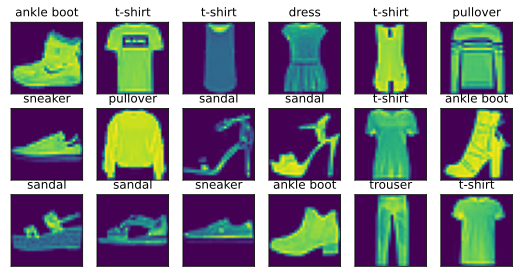

In [ ]:
X = tf.constant(mnist_train[0][:18])
y = tf.constant(mnist_train[1][:18])
show_images(X, 3, 6, titles=get_fashion_mnist_labels(y));

## 读取小批量

为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建一个。
回顾一下，在每次迭代中，数据加载器每次都会读取一小批量数据，大小为`batch_size`。我们在训练数据迭代器中还随机打乱了所有样本。


In [ ]:
batch_size = 256
train_iter = tf.data.Dataset.from_tensor_slices(mnist_train).batch(
    batch_size).shuffle(len(mnist_train[0]))

让我们看一下读取训练数据所需的时间。


In [ ]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'0.12 sec'

## 整合所有组件

现在我们定义了 `load_data_fashion_mnist` 函数，用于获取和读取Fashion-MNIST数据集。它返回训练集和验证集的数据迭代器。此外，它还接受一个可选参数，用来将图像大小调整为另一种形状。


In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # 将所有数字除以255，使所有像素值介于0和1之间，在最后添加一个批处理维度，
    # 并将标签转换为int32。
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, resize, resize)
                              if resize else X, y)
    return (tf.data.Dataset.from_tensor_slices(
        process(*mnist_train)).batch(batch_size).shuffle(len(
            mnist_train[0])).map(resize_fn),
            tf.data.Dataset.from_tensor_slices(
                process(*mnist_test)).batch(batch_size).map(resize_fn))

下面，我们通过指定`resize`参数来测试`load_data_fashion_mnist`函数的图像大小调整功能。


In [ ]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(32, 64, 64, 1) <dtype: 'float32'> (32,) <dtype: 'int32'>


我们现在已经准备好在下面的章节中使用Fashion-MNIST数据集。

## 小结

* Fashion-MNIST是一个服装分类数据集，由10个类别的图像组成。我们将在后续章节中使用此数据集来评估各种分类算法。
* 我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或($h$, $w$)。
* 数据迭代器是获得更高性能的关键组件。依靠实现良好的数据迭代器，利用高性能计算来避免减慢训练过程。



# softmax回归的从零开始实现


我们使用刚刚引入的Fashion-MNIST数据集，并设置数据迭代器的批量大小为256。

In [ ]:
import tensorflow as tf
from IPython import display
from d2l import tensorflow as d2l

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

这里的每个样本都用固定长度向量表示。原始数据集中的每个样本都是 $28 \times 28$ 的图像。在本节中，我们将展平每个图像，将它们视为长度为784的向量。在以后的章节中，我们将讨论能够利用图像空间结构的复杂策略，但现在我仅将每个像素位置视为一个特征。

回想一下，在softmax回归中，我们的输出与类别一样多。因为我们的数据集有10个类别，所以网络输出维度为 10。因此，权重将构成一个 $784 \times 10$ 的矩阵，偏置将构成一个 $1 \times 10$ 的行向量。与线性回归一样，我们将使用正态分布初始化我们的权重 `W`，偏置初始化为0。


In [ ]:
num_inputs = 784
num_outputs = 10

W = tf.Variable(
    tf.random.normal(shape=(num_inputs, num_outputs), mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

## 定义softmax操作

给定一个矩阵`X`，我们可以对所有元素求和（默认情况下），也可以只求同一个轴上的元素，即同一列（轴0）或同一行（轴1）。如果 `X` 是一个形状为 `(2, 3)` 的张量，我们对列进行求和，则结果将是一个具有形状 `(3,)` 的向量。当调用sum运算符时，我们可以指定保持在原始张量的轴数，而不折叠求和的维度。这将产生一个具有形状 `(1, 3)` 的二维张量。


In [ ]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

我们现在已经准备好实现softmax操作了。回想一下，softmax 由三个步骤组成：
（1）对每个项求幂（使用`exp`）；
（2）对每一行求和（小批量中每个样本是一行），得到每个样本的归一化常数；
（3）将每一行除以其归一化常数，确保结果的和为1。
在查看代码之前，让我们回顾一下这个表达式：

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$

分母或归一化常数，有时也称为*配分函数*（其对数称为对数-配分函数）。该名称的起源来自 [统计物理学](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))中一个模拟粒子群分布的方程。


In [ ]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制

正如你所看到的，对于任何随机输入，我们将每个元素变成一个非负数。此外，因为概率的要求，每行总和为1。


In [ ]:
X = tf.random.normal((2, 5), 0, 1)
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.3156824 , 0.209258  , 0.15375979, 0.16024598, 0.16105379],
        [0.2851689 , 0.34397066, 0.08417364, 0.16231295, 0.12437379]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.       , 0.9999999], dtype=float32)>)

注意，虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点。

## 定义模型

现在我们已经定义了softmax操作，我们可以实现softmax回归模型。下面的代码定义了输入如何通过网络映射到输出。注意，在将数据传递到我们的模型之前，我们使用 `reshape` 函数将每张原始图像展平为向量。


In [ ]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

## 定义损失函数

接下来，我们需要实现 :numref:`sec_softmax` 中引入的交叉熵损失函数。这可能是深度学习中最常见的损失函数，因为目前分类问题的数量远远超过回归问题。

回顾一下，交叉熵采用真实标签的预测概率的负对数似然。我们不需要使用Python的for循环迭代预测（这往往是低效的）。我们可以通过一个运算符选择所有元素。
下面，我们一个演示数据，其中包含2个样本在3个类别的预测概率`y_hat`。以及它们对应的标签`y`。
有了`y`，我们知道在第一个样本中，第一类是正确的预测，而在第二个样本中，第三类是正确的预测。
然后使用`y`作为`y_hat`中概率的索引，我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。


In [ ]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

现在我们只需一行代码就可以实现交叉熵损失函数。


In [ ]:
def cross_entropy(y_hat, y):
    return -tf.math.log(
        tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

## 分类准确率

在给定预测概率分布 `y_hat`时，当我们必须输出硬预测（hard prediction）时，我们通常选择预测概率最高的类。许多应用都要求我们做出选择。如Gmail必须将电子邮件分为“Primary（主要）”、“Social（社交）”、“Updates（更新）”或“Forums（论坛）”。它可能在内部估计概率，但最终它必须在类中选择一个。

当预测与标签分类 `y` 一致时，它们是正确的。分类准确率即正确预测数量与总预测数量之比。虽然直接优化准确率可能很困难（因为准确率的计算不可导），但准确率通常是我们最关心的性能衡量标准，我们在训练分类器时几乎总是会报告它。

为了计算准确率，我们执行以下操作。首先，如果 `y_hat` 是矩阵，第二个维度存储每个类的预测分数。我们使用 `argmax` 获得每行中最大元素的索引来获得预测类别。然后我们将预测类别与真实 `y` 元素进行比较。由于等式运算符 `==` 对数据类型很敏感，因此我们将 `y_hat` 的数据类型转换为与 `y` 的数据类型一致。结果是一个包含 0（错）和 1（对）的张量。进行求和会得到正确预测的数量。


In [ ]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

我们将继续使用之前定义的变量 `y_hat` 和 `y` 分别作为预测的概率分布和标签。我们可以看到，第一个样本的预测类别是2（该行的最大元素为0.6，索引为2），这与实际标签0不一致。第二个样本的预测类别是2（该行的最大元素为0.5，索引为 2），这与实际标签2一致。因此，这两个样本的分类准确率率为0.5。


In [ ]:
accuracy(y_hat, y) / len(y)

0.5

同样，我们可以评估数据迭代器 `data_iter` 访问的数据集在任意模型 `net` 上的准确率。


In [ ]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度。"""
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), tf.size(y).numpy())
    return metric[0] / metric[1]

这里 `Accumulator` 是一个实用程序类，用于对多个变量进行累加。
在上面的 `evaluate_accuracy` 函数中，我们在 `Accumulator` 实例中创建了 2 个变量，用于分别存储正确预测的数量和预测的总数量。当我们遍历数据集时，两者都将随着时间的推移而累加。


In [ ]:
class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

由于我们使用随机权重初始化 `net` 模型，因此该模型的准确率应接近于随机猜测。例如在有10个类别情况下的准确率为0.1。


In [ ]:
evaluate_accuracy(net, test_iter)

0.1273

## 训练

如果你看过 :numref:`sec_linear_scratch` 中的线性回归实现，softmax回归的训练过程代码应该看起来非常熟悉。在这里，我们重构训练过程的实现以使其可重复使用。首先，我们定义一个函数来训练一个迭代周期。请注意，`updater` 是更新模型参数的常用函数，它接受批量大小作为参数。它可以是封装的`d2l.sgd`函数，也可以是框架的内置优化函数。


In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）。"""
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras内置的损失接受的是（标签，预测），这不同于用户在本书中的实现。
            # 本书的实现接受（预测，标签），例如我们上面实现的“交叉熵”
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras的`loss`默认返回一个批量的平均损失
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，我们定义了一个在动画中绘制数据的实用程序类。它能够简化本书其余部分的代码。


In [ ]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

接下来我们实现一个训练函数，它会在`train_iter` 访问到的训练数据集上训练一个模型`net`。该训练函数将会运行多个迭代周期（由`num_epochs`指定）。在每个迭代周期结束时，利用 `test_iter` 访问到的测试数据集对模型进行评估。我们将利用 `Animator` 类来可视化训练进度。


In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

作为一个从零开始的实现，我们使用 :numref:`sec_linear_scratch` 中定义的小批量随机梯度下降来优化模型的损失函数，设置学习率为0.1。


In [ ]:
class Updater():  #@save
    """用小批量随机梯度下降法更新参数。"""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

现在，我们训练模型10个迭代周期。请注意，迭代周期（`num_epochs`）和学习率（`lr`）都是可调节的超参数。通过更改它们的值，我们可以提高模型的分类准确率。


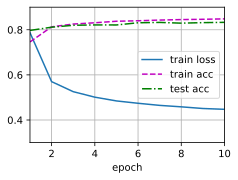

In [ ]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 预测

现在训练已经完成，我们的模型已经准备好对图像进行分类。给定一系列图像，我们将比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）。


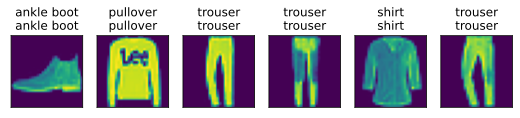

In [ ]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 小结

* 借助 softmax 回归，我们可以训练多分类的模型。
* softmax 回归的训练循环与线性回归中的训练循环非常相似：读取数据、定义模型和损失函数，然后使用优化算法训练模型。正如你很快就会发现的那样，大多数常见的深度学习模型都有类似的训练过程。

## 练习

1. 在本节中，我们直接实现了基于数学定义softmax运算的`softmax`函数。这可能会导致什么问题？提示：尝试计算 $\exp(50)$ 的大小。
1. 本节中的函数 `cross_entropy` 是根据交叉熵损失函数的定义实现的。这个实现可能有什么问题？提示：考虑对数的值域。
1. 你可以想到什么解决方案来解决上述两个问题？
1. 返回概率最大的标签总是一个好主意吗？例如，医疗诊断场景下你会这样做吗？
1. 假设我们希望使用softmax回归来基于某些特征预测下一个单词。词汇量大可能会带来哪些问题?


# softmax回归的简洁实现


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

softmax 回归的输出层是一个全连接层。因此，为了实现我们的模型，我们只需在 `Sequential` 中添加一个带有10个输出的全连接层。同样，在这里，`Sequential` 并不是必要的，但我们可能会形成这种习惯。因为在实现深度模型时，`Sequential`将无处不在。我们仍然以均值0和标准差0.01随机初始化权重。


In [ ]:
net = tf.keras.models.Sequential()
net.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
weight_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
net.add(tf.keras.layers.Dense(10, kernel_initializer=weight_initializer))

## 重新审视Softmax的实现

在前面的例子中，我们计算了模型的输出，然后将此输出送入交叉熵损失。从数学上讲，这是一件完全合理的事情。然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数 $\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，其中$\hat y_j$是预测的概率分布。$o_j$是未归一化的预测$\mathbf{o}$的第$j$个元素。如果$o_k$中的一些数值非常大，那么 $\exp(o_k)$ 可能大于数据类型容许的最大数字（即 *上溢*（overflow））。这将使分母或分子变为`inf`（无穷大），我们最后遇到的是0、`inf` 或 `nan`（不是数字）的 $\hat y_j$。在这些情况下，我们不能得到一个明确定义的交叉熵的返回值。

解决这个问题的一个技巧是，在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。你可以证明每个 $o_k$ 按常数进行的移动不会改变softmax的返回值。在减法和归一化步骤之后，可能有些 $o_j$ 具有较大的负值。由于精度受限， $\exp(o_j)$ 将有接近零的值，即 *下溢*（underflow）。这些值可能会四舍五入为零，使 $\hat y_j$ 为零，并且使得 $\log(\hat y_j)$ 的值为 `-inf`。反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。如下面的等式所示，我们避免计算$\exp(o_j)$，而可以直接使用$o_j$。因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j)}{\sum_k \exp(o_k)}\right) \\
& = \log{(\exp(o_j))}-\log{\left( \sum_k \exp(o_k) \right)} \\
& = o_j -\log{\left( \sum_k \exp(o_k) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，而是在交叉熵损失函数中传递未归一化的预测并同时计算softmax及其对数，这是一件聪明的事情 ["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)。


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## 优化算法

在这里，我们使用学习率为0.1的小批量随机梯度下降作为优化算法。这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [ ]:
trainer = tf.keras.optimizers.SGD(learning_rate=.1)

## 训练

接下来我们调用上一节中定义的训练函数来训练模型。


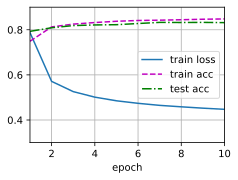

In [ ]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 重点

在高斯噪声的假设下，最小化均方误差等价于对线性模型的最大似然估计。

打乱一个列表

In [ ]:
import random
x=list(range(5))
random.shuffle(x)
x

[3, 1, 2, 4, 0]

利用Animator使数据动起来

In [ ]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])